# Práctica 3. Mínimos cuadrados y algoritmos de recomendación


### 1. Ajuste por mínimos cuadrados


El término **mínimos cuadrados** describe el problema muy frecuente de resolver sistemas de ecuaciones lineales $Ax=b$ "sobredimensionados", i.e. sistemas lineales con más ecuaciones que incógnitas (es decir, matrices $A$ con más filas que columnas). En tal caso, como normalmente no existe tal solución, en lugar de resolver las ecuaciones de manera exacta se busca sólo una "solución" que haga a $Ax$ _tan próximo_ a $b$ como sea posible.


**Definición.** Sea $Ax = b$ un sistema de $m$ ecuaciones lineales con $n$ incógnitas. Llamamos **problema lineal de mínimos cuadrados** (PLMC) al problema de hallar los vectores $x_0\in\mathbb{R}^n$ que minimicen $|| Ax_0-b ||^2$. Si $x_0$ es una solución del PLMC asociado a $Ax = b$, llamaremos **error cuadrático** a $||Ax_0 - b||^2$.


Observemos que, como generalmente $A$ no será una matriz cuadrada, al multiplicar por su traspuesta a ambos lados de $Ax=b$ conseguimos otro sistema de ecuaciones donde la matriz de coeficientes sí que es cuadrada (y simétrica): $A^tAx=A^tb$. Llamaremos **ecuaciones normales** asociadas al sistema $Ax = b$ al sistema de ecuaciones $A^tAx = A^tb$.


**Teorema.** Si $Ax = b$ es un sistema de ecuaciones lineales con $A\in\mathcal{M}_{m\times n}(\mathbb{R})$, entonces el
PLMC **siempre tiene solución**. Sus soluciones son las mismas que resuelven las ecuaciones normales asociadas al sistema. Además, la solución es única si, y solo si, $rg(A)=n$.


**Ejemplo.** Supongamos que queremos hallar un polinomio de grado 2 que mejor aproxime a los puntos $\{(-2, 3), (-1, 1), (0, 0), (1, 2)\}$. Por tanto, queremos hallar un polinomio $p(x)=a_0+a_1x+a_2x^2$ tal que 


$$ 3 = p(-2) = a_0 + -2a_1 + 4a_2 \\
1 = p(-1) = a_0 - a_1 + a_2 \\
0 = p(0) = a_0 \\
2 = p(1) = a_0 + a_1 + a_2. $$


Por tanto, el problema a resolver es $Ax=b$ donde $A=\begin{pmatrix} 1&-2&4\\1&-1&1\\1&0&0\\1&1&1 \end{pmatrix}$ y $b=\begin{pmatrix} 3\\1\\0\\2 \end{pmatrix}$. Aplicando el teorema anterior, existe solución del PLMC y es única pues $rg(A)=3$ (pues $A$ contiene a una matriz de Vandermonde). 

In [ ]:
import numpy as np
from scipy import linalg as la

In [ ]:
A=np.array([[1,-2,4],[1,-1,1],[1,0,0],[1,1,1]])
b=np.array([[3],[1],[0],[2]])

np.linalg.matrix_rank(A)

En este caso, como la solución es única, entonces $A^tA$ será invertible y podemos usar la instrucción `la.solve` para resolver $A^tAx=A^tb$. Si la solución no fuese única, deberíamos resolver dicho sistema usando `sympy.Matrix().rref()`.

In [ ]:
print(la.solve(A.T@A, A.T@b))  # solución al PLMC
x0=la.solve(A.T@A, A.T@b)
print(la.norm(A@x0-b))         # error cuadrático cometido en la aproximación

Por tanto, el polinomio de grado dos que mejor aproxima a los puntos anteriores es $p(x)=0.3+0.6x+x^2$.

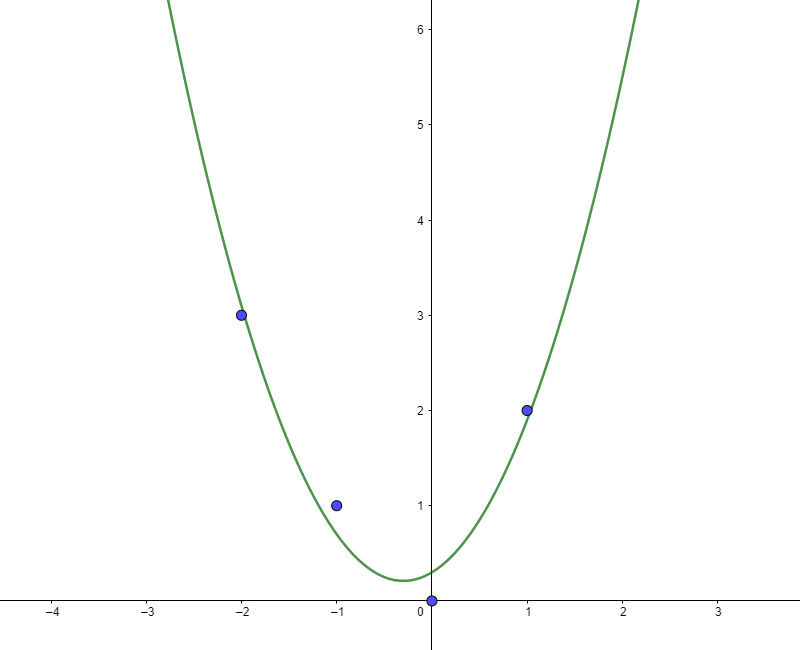

### 2. Algoritmos de recomendación


Un **sistema de recomendación** es un algoritmo que nos permite dar predicciones de cuál es el producto o ítem más adecuado para un usuario. Los sistemas de recomendación pueden ser de varias clases según el algoritmo utilizado, aunque solo nos centraremos en la presente práctica en los de _filtrado colaborativo_ . 


Los sistemas de recomendación basados en algoritmos de **filtrado colaborativo** utilizan las valoraciones o interacciones de los usuarios sobre ciertos elementos del conjunto de productos, con el objetivo de predecir valoraciones o interacciones en el resto de los elementos y recomendar los de mayor valoración predicha. Ejemplos en esta línea pueden ser **Netflix**, **Spotify**, **Youtube**, etc.


Los datos iniciales de los que disponemos son una base de datos de usuarios o clientes $(user_1, user_2, \ldots, user_M)$ a los que vamos a recomendar una serie de productos o ítems $(ítem_1, ítem_2,\ldots, item_N)$, y las interacciones o puntuaciones de esos usuarios sobre algunos de los ítems, matriz $L$ de dimensión $M\times N$. Trabajemos con el siguiente ejemplo ilustrativo, donde suponemos que 20 usuarios han valorado entre 1 y 5 algunas películas.


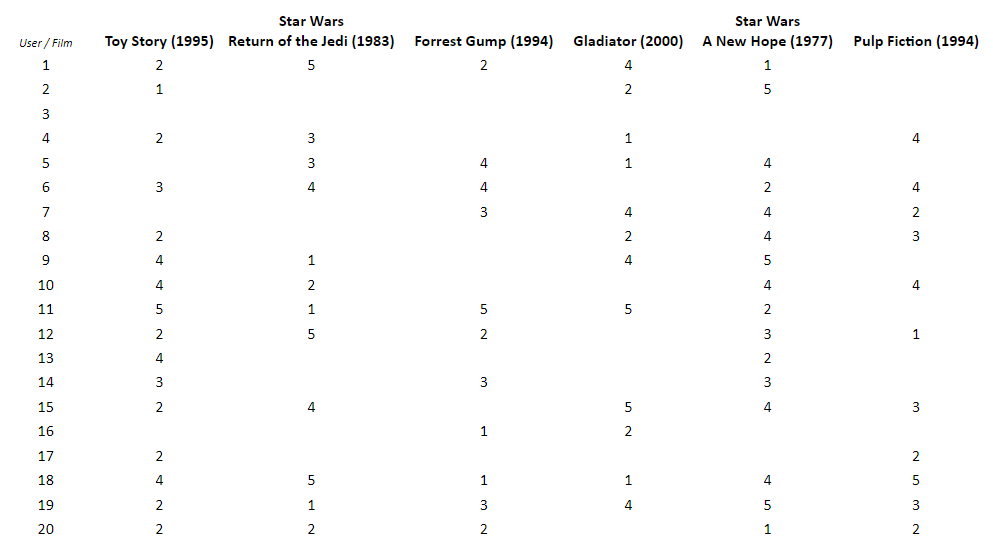


Por tanto, tenemos 20 usuarios y 6 productos, luego podemos formar nuestra matriz $L$ de dimensión $20 \times 6$, completando con ceros las entradas vacías (i.e. películas sin puntuar aún).

In [ ]:
L=np.array([[2,5,2,4,1,0],
            [1,0,0,2,5,0],
            [0,0,0,0,0,0],
            [2,3,0,1,0,4],
            [0,3,4,1,4,0],
            [3,4,4,0,2,4],
            [0,0,3,4,4,2],
            [2,0,0,2,4,3],
            [4,1,0,4,5,0],
            [4,2,0,0,4,4],
            [5,1,5,5,2,0],
            [2,5,2,0,3,1],
            [4,0,0,0,2,0],
            [3,0,3,0,3,0],
            [2,4,0,5,4,3],
            [0,0,1,2,0,0],
            [2,0,0,0,0,2],
            [4,5,1,1,4,5],
            [2,1,3,4,5,3],
            [2,2,2,0,1,2]])

Dos filtrados colaborativos célebres son:


1. User-user: personas con intereses similares en el pasado es probable que tengan intereses similares en el futuro. Por tanto, a la hora de recomendar a un usuario un ítem, nos fijamos en los intereses en los que se han interesado usuarios similares a él .


**Ejemplo.** Helena ha visto Juego de Tronos y Breaking Bad. Esperanzo ha visto Juego de Tronos, Breaking Bad y Vikingos. El algoritmo detecta que Helena y Esperanzo son usuarios similares, luego el sistema recomienda Vikingos a Helena.


2. Ítem-ítem: si a un usuario le ha interesado en el pasado un producto, es probable que en el futuro le interesen productos similares. Por tanto, a la hora de recomendar a un usuario un ítem, nos fijamos en ítems similares a los que se ha interesado en el pasado.


**Ejemplo.** Titanic ha sido vista por Helena, María y Esperanzo. Origen ha sido vista por María y Esperanzo. El algoritmo detecta que Titanic y Origen son productos similares, luego el sistema recomienda a Helena ver Origen.


Queda de manifiesto, por tanto, que la clave es conocer la similitud entre usuarios o ítems, siendo siempre la segunda opción más "manejable", pues normalmente hay muchos más usuarios que ítems, i.e. $M>>N$. Y ¿cómo podemos afirmar que dos ítems son similares? A modo de ejemplo, supongamos que solamente tuviesemos 5 usuarios y que las puntuaciones obtenidas por Matrix y The Sixth Sense fuesen $(5,2,4,0,3)$ y $(5,2,4,1,3)$, respectivamente. Claramente, son puntuaciones muy parecidas, luego el algoritmo debería detectar dicha similitud. 


Existen muchos tipos de medidas de similitud, pero nosotros usaremos la proporcionada por la **distancia del coseno**: 


$$ \text{sim}_{(\text{ítem}_1, \text{ítem}_2)}=\dfrac{\langle \text{ítem}_1 , \text{ítem}_2\rangle}{||\text{ítem}_1|| ·||\text{ítem}_2||}=\text{cos}(\text{ángulo}(\text{ítem}_1 , \text{ítem}_2))\in[-1,1],$$ 


donde $\text{ítem}_i$ es un vector con las puntuaciones obtenidas por todos los usuarios sobre el ítem $i$. (En el caso de querer hallar similitudes entre usuarios, usaríamos una fórmula análoga pero entre usuarios, donde $user_i$ sería un vector con las puntuaciones otorgadas por el usuario $i$ sobre todos los productos.) La siguiente imagen ayuda a comprender de dónde proviene esta fórmula.


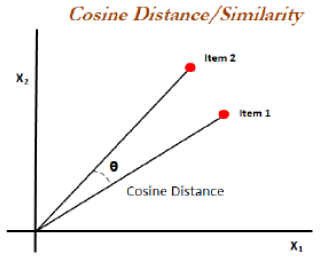


Ahora creamos una **matriz de similitud** entre ítems, de dimensión $6\times 6$, usando la fórmula anterior. Observemos que dicha matriz será necesariamente simétrica y sus entradas oscilarán entre -1 y 1.

In [ ]:
S=np.zeros((6,6))
S[0,0]=((L[:,0].T)@L[:,0])/(la.norm(L[:,0])*la.norm(L[:,0]))    # similitud entre ítem 1 e ítem 1
S[0,1]=((L[:,0].T)@L[:,1])/(la.norm(L[:,0])*la.norm(L[:,1]))    # similitud entre ítem 1 e ítem 2

print(S[0,0])    # obviamente, debe dar 1
print(S[0,1])

In [ ]:
# método más rápido: usando bucles for

S=np.zeros((L.shape[1],L.shape[1]))
for i in range(L.shape[1]):
    for j in range(L.shape[1]):
        S[i,j]=((L[:,i].T)@L[:,j])/(la.norm(L[:,i])*la.norm(L[:,j]))
print(np.round(S,3))

Luego, por ejemplo, Toy Story y Star Wars A New Hope tienen una similitud de 74.7%. 


Ahora, para calcular la película que más le pueda interesar al usuario 7, bastará con multiplicar su vector de puntuaciones por cada una de las columnas de la matriz $S$ y ver cuál es el resultado más alto.

In [ ]:
print(L[6,:])                     # puntuaciones del usuario 2 a las películas
print(np.round(L[6,:]@S,3))       # valores de recomendación en base a sus puntuaciones y a la similitud entre películas

Por tanto, fijándonos en todas las entradas que tenía nulas (i.e. películas que no había puntuado, porque no las había visto), optaríamos por recomendarle Toy Story, por tener el valor más alto. En general, podemos hacer este proceso con todos los usuarios multiplicando la matriz $L$ por $S$.

In [ ]:
print(np.round(L@S,2))     # cada fila representa los valores de recomendación para cada usuario

print(L[13,:])            # puntuaciones del usuario 14: luego por similitud le recomendamos Gladiator

### 3. Ejercicios


1. Para medir el rendimiento del motor de un avión durante el despegue de un avión, se midió su posición horizontal cada segundo, desde $t = 0$ hasta $t = 12$. Las posiciones obtenidas fueron $0, 8.8, 29.9, 62.0, 104.7, 159.1, 222.0, 294.5, 380.4, 471.1, 571.7, 686.8, 809.2$. Determina la curva cúbica de mínimos cuadrados $y = a_0 + a_1t + a_2t^2 + a_3t^3$ para estos
datos. Utiliza el resultado para estimar la velocidad del avión cuando $t=4.5$ y $t=14.5$. ¿Podemos confiar en ambas aproximaciones? Razona tu respuesta.


2. Un objeto se suspende en un túnel de viento y se mide la fuerza para varios niveles de velocidad del viento. Los datos obtenidos están tabulados en la siguiente tabla. Obtén la recta que mejor ajusta a estos datos. ¿Qué fuerza debemos esperar para una velocidad del viento de 36 m/s?

$$ \begin{array}{|c|c|c|c|c|c|c|c|c|} \hline\\ \text{velocidad (m/s)} &10& 20& 30& 40& 50& 60& 70& 80 \\ \hline \\ \text{fuerza (N)}& 25& 70& 380& 550 &610 &1120& 830& 1450 \\ \hline \end{array}  $$


3. Supongamos que en el último mes 10 usuarios están buscando en la página de Vueling vuelos desde Madrid a Málaga (AGP), Las Palmas de Gran Canaria (LPA), Sevilla (SVQ), Valencia (VLC), Ibiza (IBZ) y Santiago de Compostela (SCQ). Supongamos que la fila $i$ de la siguiente matriz representa el número de búsquedas que ha realizado el usuario $i$ sobre cada una de las rutas antes mencionadas (en el orden citado). A vista de dicha matriz, ¿qué vuelo le recomendarías a los usuarios 1 y 2? ¿Y a los usuarios 3, 5, 7 y 10? Realiza un algoritmo de recomendación ítem-ítem con el objetivo de recomendar a cada usuario un vuelo y responde de nuevo a las preguntas anteriores.

`L=np.array([[0., 0., 1., 0., 0., 2.], [0., 2., 1., 1., 0., 0.], [0., 0., 1., 1., 1., 1.], [0., 0., 1., 2., 0., 0.], [0., 0., 1., 1., 0., 0.], [0., 0., 2., 0., 0., 1.], [1., 0., 0., 1., 0., 1.], [0., 1., 0., 1., 0., 2.], [1., 2., 0., 0., 0., 1.], [1., 0., 1., 0., 1., 0.]])` 